Мгновенное выполнение Tensorflow - это среда императивного программирования, которая выполняет операции немедленно, без построения графов: операции возвращают конкретные значения вместо построения вычислительного графа для последующего запуска. Это делает проце знакомство с Tensorflow и дебаггинг моделей, а так же уменьшает количество бойллерплет-кода. 
Чтобы пройти этот гайд, просто запускайте сэмплы кода ниже в интерактивном интерпретаторе питона.

Мгновенное выполнение - это гибкая платформа машинного обучения для исследований и эксперементов, предоставляющая:

- Интуитивно понятный интерфейс. 
Структурируйте свой код естественным образом и используйте структуры данных Python. Быстро перебирайте небольшие модели и небольшие данные.
- Упрощенная отладка.
Вызовите операторы напрямую, чтобы проверить работающие модели и протестировать изменения. Используйте стандартные инструменты отладки Python для немедленного сообщения об ошибках.
- Естественный поток управления.
Используйте поток управления Python вместо потока управления графом, что упрощает спецификацию динамических моделей. 

Мгновенное выполнение поддерживает большинство операций Tensorflow с GPU-ускорением.

In [1]:
import os
import tensorflow as tf
import cProfile

In [2]:
tf.executing_eagerly()

True

In [3]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


Включение немедленного выполнения изменяет поведение операций TensorFlow - теперь они немедленно вычисляют и возвращают  значения в Python. Объекты tf.Tensor ссылаются на конкретные значения вместо символических указателей на узлы в вычислительном графе. Поскольку нет вычислительного графа, который можно было бы построить и запустить позже в сеансе, легко проверить результаты с помощью print () или отладчика. Оценка, печать и проверка значений тензора не прерывают процесс вычисления градиентов.

Немедленное выполнение прекрасно работает с NumPy. Операции NumPy принимают аргументы tf.Tensor. Операции TensorFlow tf.math преобразуют объекты Python и массивы NumPy в объекты tf.Tensor. Метод tf.Tensor.numpy возвращает значение объекта в виде массива NumPy ndarray.

In [4]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [5]:
# Broadcasting support
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [6]:
# Operator overloading is supported
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [7]:
# Use NumPy values
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [8]:
# Obtain numpy value from a tensor:
print(a.numpy())

[[1 2]
 [3 4]]


Динамический поток управления

Основным преимуществом немедленного выполнения является то, что все функции основного языка доступны во время работы вашей модели. Можно, например, легко написать fizzbuzz:

In [9]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(num.numpy())
        counter += 1

In [10]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


Мгновенное обучение.
Вычислительные градиенты

Автоматическое дифференцирование полезно для реализации алгоритмов машинного обучения(таких как обратное распространение) в обучении нейронных сетей. Во время мгновенного выполнения используйте tf.GradientTape для последующего отслеживания операций вычисления градиентов.

Вы можете использовать tf.GradientTape для обучения и/или вычисления градиентов в в режиме "мгновенности". Это особенно полезно для сложных тренировочных циклов.

Поскольку во время каждого вызова могут происходить разные операции, все операции прямого прохода записываются на «ленту». Чтобы вычислить градиент, воспроизведите ленту в обратном направлении, а затем сбросьте ее. Конкретный tf.GradientTape может вычислять только один градиент; последующие вызовы вызывают runtime error.

In [11]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w * w

grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


Обучение модели.

В следующем примере создается многослойная модель, которая классифицирует стандартные рукописные цифры MNIST. Он демонстрирует оптимизатор и API слоев для построения обучаемых графов в среде активного выполнения.

In [12]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [13]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [14]:
for images,labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.02827129  0.06314638 -0.00411888  0.05851702  0.04092003 -0.01320333
   0.03471756 -0.02061576  0.03115047 -0.02320231]]


Хотя модели keras имеют встроенный цикл обучения (с использованием метода fit), иногда вам требуется дополнительная настройка. Вот пример цикла обучения, реализованного с помощью eager:

In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [16]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)

        # Add asserts to check the shape of the output.
        tf.debugging.assert_equal(logits.shape, (32, 10))

        loss_value = loss_object(labels, logits)

    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [17]:
def train(epochs):
    for epoch in range(epochs):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print ('Epoch {} finished'.format(epoch))

In [18]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

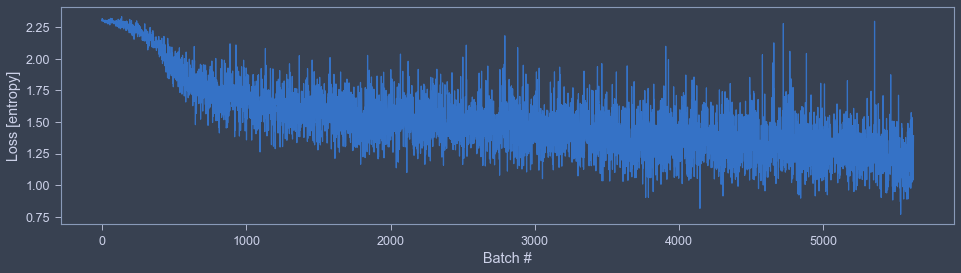

In [22]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(20, 5))

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

Переменные и оптимизаторы

Объекты tf.Variable хранят изменяемые tf.Tensor-подобные значения, к которым осуществляется доступ во время обучения, чтобы упростить автоматическое дифференцирвоание.

Коллекции переменных могут быть инкапсулированы вместе с методами, которые с ними работают в слои или модели. Основное различие между слоями и моделями заключается в том, что модели добавляют такие методы, как Model.fit, Model.evaluate и Model.save.

Например, приведенный выше пример автоматического дифференцирования можно переписать: 

In [24]:
class Linear(tf.keras.Model):
    def __init__(self):
        super(Linear, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
    def call(self, inputs):
        return inputs * self.W + self.B

In [25]:
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

Создайте модель.
Производные функции потерь по параметрам модели.
Стратегия обновления переменных на основе производных.

In [26]:
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

steps = 300
for i in range(steps):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

Initial loss: 67.999
Loss at step 000: 65.406
Loss at step 020: 30.258
Loss at step 040: 14.304
Loss at step 060: 7.050
Loss at step 080: 3.746
Loss at step 100: 2.238
Loss at step 120: 1.550
Loss at step 140: 1.235
Loss at step 160: 1.090
Loss at step 180: 1.024
Loss at step 200: 0.994
Loss at step 220: 0.980
Loss at step 240: 0.973
Loss at step 260: 0.970
Loss at step 280: 0.969


In [27]:
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

Final loss: 0.968


In [28]:
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

W = 3.013296365737915, B = 1.9718258380889893


Объектно-ориентированное сохранение.

tf.keras.Model включает удобный save_weights метод, позволяющий легко создать checkpoint:

In [30]:
model.save_weights('weights')
status = model.load_weights('weights')

Используя tf.train.Checkpoint можно полностью контролировать этот процесс.
Этот раздел представляет собой сокращенную версию руководства по чекпойнтам.

In [31]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = './ckpt/'
checkpoint.save(checkpoint_path)

'./ckpt/-1'

x.assign(11.)  # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


Для сохранения и загрузки моделей tf.train.Checkpoint сохраняет внутреннее состояние объектов, не требуя скрытых переменных. Чтобы записать состояние модели, оптимизатора и глобального шага, передайте их в tf.train.Checkpoint:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))